In [1]:
import random
from numpy.random import seed
seed(3)
import numpy as np
np.random.default_rng
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from pandas import read_csv
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from os.path import expanduser as ospath
import time
import os
os.chdir("C:/Users/rober/project/B_Data_pre_processing/My_functions")
from B_pre_processing_data import pre_process_db
from A_merge_datasets import merge_select_columns 
from C_metrics_binary import calc_binary_class_metrics
os.chdir("C:/Users/rober/project/F_Extra_Experiments_Abstracts/")


import xgboost as xgb
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.model_selection import KFold,GridSearchCV, cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE


## Load Pickley files
I load the **test features and test targets** that I used to learn the Binary classification model saved in **'project\E_Models\Abstracts'**. I need the test dataset to evaluate the new learning model which I train with data labelled using keywords search with data manually labelled data. 

In [2]:
with open(ospath('~/final_project/E_Models/Abstracts/Pickle_Files/X_test_abstracts.pickle'), 'rb') as data:
    X_test = pickle.load(data)
    
with open(ospath('~/final_project/E_Models/Abstracts/Pickle_Files/y_test_abstracts.pickle'), 'rb') as data:
    y_test = pickle.load(data)
    
with open(ospath('~/final_project/B_Data_pre_processing/Pickle_Files/Abstracts_cleaned.pickle'), 'rb') as data:
    db = pickle.load(data)
    
with open(ospath('~/code_final_project/E_Models/Abstracts/Pickle_Files/X_train_abstracts.pickle'), 'rb') as data:
    X_train = pickle.load(data)
    
with open(ospath('~/final_project/E_Models/Abstracts/Pickle_Files/y_train_abstracts.pickle'), 'rb') as data:
    y_train = pickle.load(data)

In [3]:
X_test.head()

1019    seal lead-acid battery assembly motive power v...
254     positive active material accord one embodiment...
884     disclose flywheel system store kinetic energy ...
712     hybrid electric motor vehicle drive charge gas...
359     network collection charge distribution machine...
Name: text_clean, dtype: object

### Load all the datasets collected from USPTO and EPO offices, which are unlabelled.
Data collected using the scripts in **'project\A_Data_Collection'** and stored in **'project/Unlabelled_data'**.

#### USPTO

In [4]:
#USPTO datasets unlabelled
dt_LIB_us = pd.read_excel(ospath('~/final_project/Unlabelled_data/DB_LIB_USPTO.xlsx'),dtype=str)
dt_LC_us = pd.read_excel(ospath('~/final_project/Unlabelled_data/DB_LC_USPTO.xlsx'),dtype=str)
dt_SC_us = pd.read_excel(ospath('~/final_project/Unlabelled_data/DB_SC_USPTO.xlsx'),dtype=str)
dt_FW_us = pd.read_excel(ospath('~/final_project/Unlabelled_data/DB_FW_USPTO.xlsx'),dtype=str)

#drops rows with NAs
dt_LIB_us = dt_LIB_us[dt_LIB_us['Publn_Nr'].notna()]
dt_LC_us = dt_LC_us[dt_LC_us['Publn_Nr'].notna()]
dt_SC_us = dt_SC_us[dt_SC_us['Publn_Nr'].notna()]
dt_FW_us = dt_FW_us[dt_FW_us['Publn_Nr'].notna()]


#keeps only three columns
dt_FW_us = dt_FW_us[['Publn_Nr', 'Type', 'Text']]
dt_LIB_us = dt_LIB_us[['Publn_Nr', 'Type', 'Text']]
dt_LC_us = dt_LC_us[['Publn_Nr', 'Type', 'Text']]
dt_SC_us = dt_SC_us[['Publn_Nr', 'Type', 'Text']]

#change the column names to lowercase 
dt_FW_us.columns = ['publn_nr', 'type', 'text']
dt_LIB_us.columns = ['publn_nr', 'type', 'text']
dt_LC_us.columns = ['publn_nr', 'type', 'text']
dt_SC_us.columns = ['publn_nr', 'type', 'text']

#converts the column Publn_Nr in intiger type
dt_LIB_us['publn_nr'] = np.int64(dt_LIB_us['publn_nr'])
dt_LC_us['publn_nr'] = np.int64(dt_LC_us['publn_nr'])
dt_FW_us['publn_nr'] = np.int64(dt_FW_us['publn_nr'])
dt_SC_us['publn_nr'] = np.int64(dt_SC_us['publn_nr'])

#### EPO

In [5]:
#EPO datasets unlabelled
dt_LIB_epo = pd.read_excel(ospath('~/final_project/Unlabelled_data/LIB_EPO.xlsx'),dtype=str)
dt_LC_epo = pd.read_excel(ospath('~/final_project/Unlabelled_data/LC_EPO.xlsx'),dtype=str)
dt_SC_epo = pd.read_excel(ospath('~/final_project/Unlabelled_data/SC_EPO.xlsx'),dtype=str)
dt_FW_epo = pd.read_excel(ospath('~/final_project/Unlabelled_data/FW_EPO.xlsx'),dtype=str)

#drops rows with NAs
dt_LIB_epo = dt_LIB_epo[dt_LIB_epo['Text'].notna()]
dt_LC_epo = dt_LC_epo[dt_LC_epo['Text'].notna()]
dt_SC_epo = dt_SC_epo[dt_SC_epo['Text'].notna()]
dt_FW_epo = dt_FW_epo[dt_FW_epo['Text'].notna()]

#converts the column Publn_Nr in intiger type
dt_LIB_epo['Publn_Nr'] = np.int64(dt_LIB_epo['Publn_Nr'])
dt_LC_epo['Publn_Nr'] = np.int64(dt_LC_epo['Publn_Nr'])
dt_FW_epo['Publn_Nr'] = np.int64(dt_FW_epo['Publn_Nr'])
dt_SC_epo['Publn_Nr'] = np.int64(dt_SC_epo['Publn_Nr'])

#keeps only three columns
dt_FW_epo = dt_FW_epo[['Publn_Nr', 'Type', 'Text']]
dt_LIB_epo = dt_LIB_epo[['Publn_Nr', 'Type', 'Text']]
dt_LC_epo = dt_LC_epo[['Publn_Nr', 'Type', 'Text']]
dt_SC_epo = dt_SC_epo[['Publn_Nr', 'Type', 'Text']]

#change the column names to lowercase 
dt_FW_epo.columns = ['publn_nr', 'type', 'text']
dt_LIB_epo.columns = ['publn_nr', 'type', 'text']
dt_LC_epo.columns = ['publn_nr', 'type', 'text']
dt_SC_epo.columns = ['publn_nr', 'type', 'text']

### I merge all the dataset together and select the rows with only abstracts. I set in the function the parameter labels as 'No' because there is no column with labels here.

In [6]:
unlab_data = merge_select_columns(dt_LIB_us, dt_SC_us, dt_FW_us, dt_LC_us, dt_LIB_epo, dt_LC_epo, dt_FW_epo, dt_SC_epo, labels = 'No')

In [7]:
unlab_data.head()

,publn_nr,type,text
0,10354828,Abstract,According to an embodiment of the present disc...
11,10085792,Abstract,An apparatus includes an instrument body and t...
31,9782215,Abstract,An ultrasonic surgical device comprises a hand...
52,10343141,Abstract,MOFs are disclosed that can efficiently adsorb...
60,10337115,Abstract,Surface treated copper foils for use in high s...


Since the unlabelled datasets have the patents that have been choosen to be manually labelled and soem of them are in test dataset, I am amking sure to delete those patents from the unlabelled datasets. 

##### *Before* deleting the patents used for the labelling phase.

In [8]:
w_train_patents = len(unlab_data['publn_nr'].unique())
print(w_train_patents)

85908


In [9]:
#save in list the publication numbers of the patents used for the logistic above
list_publ_num_uspto = db['publn_nr'].unique()

#keeps only patents that are not used to train and test the best model for the Abstracts saved
unlab_data = unlab_data[~unlab_data['publn_nr'].isin(list_publ_num_uspto)]
print(len(list_publ_num_uspto))

194


#### *After* deleting the patents used for the labelling phase.

In [10]:
no_train_patents = len(unlab_data['publn_nr'].unique())
print(no_train_patents)

85714


In [11]:
print(w_train_patents - no_train_patents)

194


I pre-process the text with my pre-process function.  

In [12]:
unlab_data = pre_process_db(unlab_data)#pre-process the text

In [13]:
unlab_data.head()

,publn_nr,type,text,text_clean
0,10354828,Abstract,According to an embodiment of the present disc...,accord embodiment present disclosure photocath...
11,10085792,Abstract,An apparatus includes an instrument body and t...,apparatus include instrument body transmission...
31,9782215,Abstract,An ultrasonic surgical device comprises a hand...,ultrasonic surgical device comprise handle ass...
52,10343141,Abstract,MOFs are disclosed that can efficiently adsorb...,mofs disclose efficiently adsorb oxygen gas st...
60,10337115,Abstract,Surface treated copper foils for use in high s...,surface treat copper foil use high speed circu...


## Keyword search
I search for process words used by Nicolas and colleague for their keyword search model (2019). 

Keyword search of a process word in the first three words of the pre-processed text. When a process word is found in the first three words of the pre-processed text, the abstract is labelled as process and prodcut otherwise. 

In [14]:
words_process = ['method' ,'process', 'procedure', 'use', 'utilization' , 'utilisation' , 'usage']
keywords_labels = []
for i in range(unlab_data.shape[0]):
    abstract = unlab_data['text_clean'].iloc[i].split(" ")
    abstract = abstract[:3]
    
    check =  any(word in abstract for word in words_process)
    if check == True:
        keywords_labels.append(0)
    else:
        keywords_labels.append(1)
unlab_data['kwsearch_1_label'] = keywords_labels

In [15]:
unlab_data.head()

,publn_nr,type,text,text_clean,kwsearch_1_label
0,10354828,Abstract,According to an embodiment of the present disc...,accord embodiment present disclosure photocath...,1
11,10085792,Abstract,An apparatus includes an instrument body and t...,apparatus include instrument body transmission...,1
31,9782215,Abstract,An ultrasonic surgical device comprises a hand...,ultrasonic surgical device comprise handle ass...,1
52,10343141,Abstract,MOFs are disclosed that can efficiently adsorb...,mofs disclose efficiently adsorb oxygen gas st...,1
60,10337115,Abstract,Surface treated copper foils for use in high s...,surface treat copper foil use high speed circu...,1


I extract the feature and their target values for the training phase.

In [16]:
X_train_ks = unlab_data['text_clean']
y_train_ks = unlab_data['kwsearch_1_label']

In [17]:
y_train_ks.value_counts()

1    93234
0    15257
Name: kwsearch_1_label, dtype: int64

I **split the unalabelled dataset** with keyword search labels into three datasets, train, validation and test data. 
*Train 50%, validation 25% and test 25%*.

In [18]:
X_train_ks, X_val_ks, y_train_ks , y_val_ks = train_test_split(unlab_data['text_clean'], 
                                                    unlab_data['kwsearch_1_label'], test_size=0.5, random_state=8, stratify = unlab_data['kwsearch_1_label'])

X_val_ks, X_test_ks, y_val_ks , y_test_ks = train_test_split(X_val_ks, 
                                                    y_val_ks, test_size=0.5, random_state=8, stratify = y_val_ks)


## Spot-check the best models.

I run the test harness directly here to reduce the number of scripts for this experiment.

In [19]:
#pipelines of the models with different vectorization methods
logi_model_tfidf = Pipeline([("tfidf", TfidfVectorizer(lowercase=False,ngram_range=(1,2), max_features=300,sublinear_tf=True)),  ('LOGI', LogisticRegression(random_state = 0, n_jobs=-1))])

xgb_model_tfidf = Pipeline([("tfidf", TfidfVectorizer(lowercase=False,ngram_range=(1,2), max_features=300,sublinear_tf=True)),  ('XGB', xgb.XGBClassifier(objective = 'binary:logistic', n_jobs=-1))])

CART_model_tfidf = Pipeline([("tfidf", TfidfVectorizer(lowercase=False,ngram_range=(1,2), max_features=300,sublinear_tf=True)) , ('CART', DecisionTreeClassifier(random_state = 0))])

RFC_model_tfidf = Pipeline([("tfidf", TfidfVectorizer(lowercase=False,ngram_range=(1,2), max_features=300,sublinear_tf=True)),('RFC', RandomForestClassifier(n_jobs=-1))])

models = []
models.append(('LOGI_tfidf', logi_model_tfidf))
models.append(('XGB_tfidf', xgb_model_tfidf))
models.append(('CART_tfidf', CART_model_tfidf))
models.append(('RFC_tfidf', RFC_model_tfidf))

#for the parameters scoring 
scoring_acc = metrics.make_scorer(metrics.accuracy_score)
scoring_prec = metrics.make_scorer(metrics.precision_score)
scoring_rec = metrics.make_scorer(metrics.recall_score)
scoring_f1 = metrics.make_scorer(metrics.f1_score)

score_list = []
score_list.append(scoring_acc)
score_list.append(scoring_prec)
score_list.append(scoring_rec)
score_list.append(scoring_f1)

names_score = ['acc', 'prec', 'rec', 'f1']
name_score_model = []

#to store results of cv in a data set
results_std = []
results_mean = []
results = []

#
time_models =[]

for name, model in models:
    for score, name_score in zip(score_list, names_score):
        kfold = KFold(n_splits=10, random_state=7)
        
        #timing the model
        start = time.time()
        results_cv = cross_val_score(model, X_train_ks, y_train_ks, cv=kfold, scoring= score)
        end = time.time()
        
        results_mean.append(round(results_cv.mean(),5))
        results_std.append(round(results_cv.std(),5))
        results.append(results_cv)
        time_models.append(round(end - start, 5))
        name_score_model.append((name, name_score))
        
name_dict_db_results = [' '.join(map(str,name_score_model[i])) for i in range(len(name_score_model))]
dictionary_results = {'Model': name_dict_db_results, 'Mean': results_mean, 'Std': results_std, 'time_models' :time_models } 
db_results = pd.DataFrame(dictionary_results)

#Adapted from - Brownlee, J. (2016) Machine learning mastery with Python: understand your data, create accurate models, and work projects end-to-end.

In [20]:
db_results

,Model,Mean,Std,time_models
0,LOGI_tfidf acc,0.90312,0.00307,61.94807
1,LOGI_tfidf prec,0.92449,0.00251,58.14142
2,LOGI_tfidf rec,0.96619,0.00257,57.39004
3,LOGI_tfidf f1,0.94488,0.00174,57.72436
4,XGB_tfidf acc,0.93081,0.00424,110.42100
5,XGB_tfidf prec,0.95699,0.00259,111.33676
6,XGB_tfidf rec,0.96277,0.00304,112.52166
7,XGB_tfidf f1,0.95987,0.00247,113.45459
8,CART_tfidf acc,0.91929,0.00346,112.22664
9,CART_tfidf prec,0.95223,0.00331,107.11535


The best two models are: **Random Forest** and **XGBoost**.

Word representation using **TF-IDF** vectorizer with a fix dimension of **300** with **unigram** and **bigram**.

In [19]:
ffidf = TfidfVectorizer(ngram_range = (1,2), encoding='utf-8', sublinear_tf = True, max_features=300)

In [20]:
tfidf = TfidfVectorizer(ngram_range = (1,2), encoding='utf-8', sublinear_tf = True, max_features=300)

X_train_ks_tf = tfidf.fit_transform(X_train_ks).toarray()
X_test_ks_tf = tfidf.transform(X_test_ks).toarray()
X_val_ks_tf = tfidf.transform(X_val_ks).toarray()


y_train_ks = y_train_ks.astype('int')
y_test_ks = y_test_ks.astype('int')
y_val_ks = y_val_ks.astype('int')

In [21]:
balance = SMOTE()
X_train_ks_bal, y_train_ks_bal = balance.fit_resample(X_train_ks_tf, y_train_ks)

I create an empty dataframe to store the results of each the models. 

In [22]:
results_score = pd.DataFrame()

## Random Forest

In [23]:
random.seed(2)
rf = RandomForestClassifier(random_state = 8, n_jobs = -1)
rf.fit(X_train_ks_bal, y_train_ks_bal)
rf_pred = rf.predict(X_val_ks_tf)

print("Accuracy on validation data: \n",metrics.accuracy_score(y_val_ks, rf_pred))
print("Classification report: \n",metrics.classification_report(y_val_ks, rf_pred))
print('Confusion Matrix validation: \n' + str(metrics.confusion_matrix(y_val_ks, rf_pred)))


Accuracy on validation data: 
 0.9365114478486893
Classification report: 
               precision    recall  f1-score   support

           0       0.74      0.84      0.79      3815
           1       0.97      0.95      0.96     23308

    accuracy                           0.94     27123
   macro avg       0.86      0.90      0.88     27123
weighted avg       0.94      0.94      0.94     27123

Confusion Matrix validation: 
[[ 3209   606]
 [ 1116 22192]]


In [24]:
sc = calc_binary_class_metrics(y_val_ks, rf_pred, 'RF not tuned', 'Validation')
results_score = results_score.append(sc)
results_score

,Model,Data,Precision,Recall,Specificity,F1-score,Accuracy,Bal Accuracy,AUC
0,RF not tuned,Validation,0.973419,0.952119,0.841153,0.962651,0.936511,0.896636,0.896636


Evaulated on the **test data** - keyword search labelled.

In [25]:
random.seed(2)
rf_pred_test = rf.predict(X_test_ks_tf)
print("Accuracy on the test data: \n", metrics.accuracy_score(y_test_ks, rf_pred_test))
print("Classification report: \n", metrics.classification_report(y_test_ks, rf_pred_test))
print('Confusion Matrix test: \n' + str(metrics.confusion_matrix(y_test_ks, rf_pred_test)))

Accuracy on the test data: 
 0.936474578770785
Classification report: 
               precision    recall  f1-score   support

           0       0.74      0.84      0.79      3814
           1       0.97      0.95      0.96     23309

    accuracy                           0.94     27123
   macro avg       0.86      0.90      0.88     27123
weighted avg       0.94      0.94      0.94     27123

Confusion Matrix test: 
[[ 3211   603]
 [ 1120 22189]]


In [26]:
sc = calc_binary_class_metrics(y_test_ks, rf_pred_test, 'RF not tuned', 'Test')
results_score = results_score.append(sc)
results_score

,Model,Data,Precision,Recall,Specificity,F1-score,Accuracy,Bal Accuracy,AUC
0,RF not tuned,Validation,0.973419,0.952119,0.841153,0.962651,0.936511,0.896636,0.896636
0,RF not tuned,Test,0.973543,0.951950,0.841898,0.962626,0.936475,0.896924,0.896924


### Tune the TF-IDF for the Random Forrest algorithm

In [27]:
random.seed(2)
pipe_grid = Pipeline([
    ('tfidf', TfidfVectorizer(lowercase=False), ),
    ('clf', OneVsRestClassifier(RandomForestClassifier(random_state = 8))),
])
param_grid = {
    'tfidf__norm' :('l1', 'l2'),
    'tfidf__max_features' : (300, 350, 400, 450,500),
    'tfidf__sublinear_tf' : [True, False]
}

grid_search_tfidf = GridSearchCV(pipe_grid, param_grid, cv=2, n_jobs=2, verbose=3)
grid_search_tfidf.fit(X_val_ks, y_val_ks)


print("Best set of parameters: \n" ,grid_search_tfidf.best_estimator_.steps)

Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  1.9min
[Parallel(n_jobs=2)]: Done  40 out of  40 | elapsed:  2.6min finished


Best set of parameters: 
 [('tfidf', TfidfVectorizer(lowercase=False, max_features=400, sublinear_tf=True)), ('clf', OneVsRestClassifier(estimator=RandomForestClassifier(random_state=8)))]


Fit the TF-IDF with the new parameters

In [28]:
tfidf_tune = grid_search_tfidf.best_estimator_[0]

X_train_ks_tf_tune = tfidf_tune.fit_transform(X_train_ks).toarray()
X_test_ks_tf_tune = tfidf_tune.transform(X_test_ks).toarray()
X_val_ks_tf_tune = tfidf_tune.transform(X_val_ks).toarray()

Balance the data again with SMOTE.

In [29]:
balance = SMOTE()
X_train_ks_tf_tune_bal, y_train_ks_tf_tune_bal = balance.fit_resample(X_train_ks_tf_tune, y_train_ks)

In [30]:
random.seed(2)
rf_tf_tune = RandomForestClassifier(random_state = 8, n_jobs = -1)
rf_tf_tune.fit(X_train_ks_tf_tune_bal, y_train_ks_tf_tune_bal)
rf_tf_tune_pred = rf_tf_tune.predict(X_val_ks_tf_tune)

print("Accuracy on validation data: \n",metrics.accuracy_score(y_val_ks, rf_tf_tune_pred))
print("Classification report: \n",metrics.classification_report(y_val_ks, rf_tf_tune_pred))
print('Confusion Matrix validation: \n' + str(metrics.confusion_matrix(y_val_ks, rf_tf_tune_pred)))


Accuracy on validation data: 
 0.9380599491206725
Classification report: 
               precision    recall  f1-score   support

           0       0.75      0.84      0.79      3815
           1       0.97      0.95      0.96     23308

    accuracy                           0.94     27123
   macro avg       0.86      0.90      0.88     27123
weighted avg       0.94      0.94      0.94     27123

Confusion Matrix validation: 
[[ 3223   592]
 [ 1088 22220]]


In [31]:
sc = calc_binary_class_metrics(y_val_ks, rf_tf_tune_pred, 'RF TF tuned', 'Validation')
results_score = results_score.append(sc)
results_score

,Model,Data,Precision,Recall,Specificity,F1-score,Accuracy,Bal Accuracy,AUC
0,RF not tuned,Validation,0.973419,0.952119,0.841153,0.962651,0.936511,0.896636,0.896636
0,RF not tuned,Test,0.973543,0.951950,0.841898,0.962626,0.936475,0.896924,0.896924
0,RF TF tuned,Validation,0.974049,0.953321,0.844823,0.963573,0.938060,0.899072,0.899072


Evaulated on the **test data** - keyword search labelled.

In [32]:
random.seed(2)
rf_tf_tune_pred_test = rf_tf_tune.predict(X_test_ks_tf_tune)
print("Accuracy on the test data: \n", metrics.accuracy_score(y_test_ks, rf_tf_tune_pred_test))
print("Classification report: \n",metrics.classification_report(y_test_ks, rf_tf_tune_pred_test))
print('Confusion Matrix test: \n' + str(metrics.confusion_matrix(y_test_ks, rf_tf_tune_pred_test)))

Accuracy on the test data: 
 0.9367326623161155
Classification report: 
               precision    recall  f1-score   support

           0       0.74      0.84      0.79      3814
           1       0.97      0.95      0.96     23309

    accuracy                           0.94     27123
   macro avg       0.86      0.90      0.88     27123
weighted avg       0.94      0.94      0.94     27123

Confusion Matrix test: 
[[ 3199   615]
 [ 1101 22208]]


In [33]:
sc = calc_binary_class_metrics(y_test_ks, rf_tf_tune_pred_test, 'RF TF tuned', 'Test')
results_score = results_score.append(sc)
results_score

,Model,Data,Precision,Recall,Specificity,F1-score,Accuracy,Bal Accuracy,AUC
0,RF not tuned,Validation,0.973419,0.952119,0.841153,0.962651,0.936511,0.896636,0.896636
0,RF not tuned,Test,0.973543,0.951950,0.841898,0.962626,0.936475,0.896924,0.896924
0,RF TF tuned,Validation,0.974049,0.953321,0.844823,0.963573,0.938060,0.899072,0.899072
0,RF TF tuned,Test,0.973053,0.952765,0.838752,0.962802,0.936733,0.895758,0.895758


### Tune the parameters of the Random Forest algorithm

In [34]:
param_grid = {'min_samples_leaf': [1, 2, 4],
              'min_samples_split' : [2, 5, 10],
             'max_features' : ['auto', 'sqrt'],
              'max_depth': [20, 40, 60, 80, 100, None],
              'n_estimators' : [200, 400, 600, 800, 1000],
             'bootstrap' : [True, False]}

In [35]:
random.seed(2)
rand_for = RandomForestClassifier(random_state=8)

random_search = RandomizedSearchCV(estimator=rand_for,
                                   param_distributions=param_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1)

# Fit the random search model
random_search.fit(X_val_ks_tf_tune, y_val_ks)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 123.5min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=8),
                   n_iter=50,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [20, 40, 60, 80, 100,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000]},
                   scoring='accuracy', verbose=1)

In [36]:
random.seed(2)
rf_both_tune = random_search.best_estimator_
rf_both_tune.fit(X_train_ks_tf_tune_bal, y_train_ks_tf_tune_bal)
rf_both_tune_pred = rf_both_tune.predict(X_val_ks_tf_tune)

print("Accuracy on validation data: \n",metrics.accuracy_score(y_val_ks, rf_both_tune_pred))
print("Classification report: \n",metrics.classification_report(y_val_ks, rf_both_tune_pred))
print('Confusion Matrix validation: \n' + str(metrics.confusion_matrix(y_val_ks, rf_both_tune_pred)))

Accuracy on validation data: 
 0.9407145227297865
Classification report: 
               precision    recall  f1-score   support

           0       0.77      0.82      0.80      3815
           1       0.97      0.96      0.97     23308

    accuracy                           0.94     27123
   macro avg       0.87      0.89      0.88     27123
weighted avg       0.94      0.94      0.94     27123

Confusion Matrix validation: 
[[ 3136   679]
 [  929 22379]]


In [37]:
sc = calc_binary_class_metrics(y_val_ks, rf_both_tune_pred, 'RF TF and Algorithm tuned', 'Validation')
results_score = results_score.append(sc)
results_score

,Model,Data,Precision,Recall,Specificity,F1-score,Accuracy,Bal Accuracy,AUC
0,RF not tuned,Validation,0.973419,0.952119,0.841153,0.962651,0.936511,0.896636,0.896636
0,RF not tuned,Test,0.973543,0.951950,0.841898,0.962626,0.936475,0.896924,0.896924
0,RF TF tuned,Validation,0.974049,0.953321,0.844823,0.963573,0.938060,0.899072,0.899072
0,RF TF tuned,Test,0.973053,0.952765,0.838752,0.962802,0.936733,0.895758,0.895758
0,RF TF and Algorithm tuned,Validation,0.970553,0.960142,0.822018,0.965319,0.940715,0.891080,0.891080


Evaulated on the **test data** - keyword search labelled.

In [38]:
random.seed(2)
rf_both_tune_pred_test = rf_both_tune.predict(X_test_ks_tf_tune)
print("Accuracy on the test data: \n", metrics.accuracy_score(y_test_ks, rf_both_tune_pred_test))
print("Classification report: \n",metrics.classification_report(y_test_ks, rf_both_tune_pred_test))
print('Confusion Matrix test: \n' + str(metrics.confusion_matrix(y_test_ks, rf_both_tune_pred_test)))

Accuracy on the test data: 
 0.9404933082623603
Classification report: 
               precision    recall  f1-score   support

           0       0.77      0.83      0.80      3814
           1       0.97      0.96      0.97     23309

    accuracy                           0.94     27123
   macro avg       0.87      0.89      0.88     27123
weighted avg       0.94      0.94      0.94     27123

Confusion Matrix test: 
[[ 3152   662]
 [  952 22357]]


In [39]:
sc = calc_binary_class_metrics(y_test_ks, rf_both_tune_pred_test, 'RF TF and Algorithm tuned', 'Test')
results_score = results_score.append(sc)
results_score

,Model,Data,Precision,Recall,Specificity,F1-score,Accuracy,Bal Accuracy,AUC
0,RF not tuned,Validation,0.973419,0.952119,0.841153,0.962651,0.936511,0.896636,0.896636
0,RF not tuned,Test,0.973543,0.951950,0.841898,0.962626,0.936475,0.896924,0.896924
0,RF TF tuned,Validation,0.974049,0.953321,0.844823,0.963573,0.938060,0.899072,0.899072
0,RF TF tuned,Test,0.973053,0.952765,0.838752,0.962802,0.936733,0.895758,0.895758
0,RF TF and Algorithm tuned,Validation,0.970553,0.960142,0.822018,0.965319,0.940715,0.891080,0.891080
0,RF TF and Algorithm tuned,Test,0.971241,0.959157,0.826429,0.965161,0.940493,0.892793,0.892793


## XGBoost

In [40]:
random.seed(2)
xb = xgb.XGBClassifier(objective = 'binary:logistic', n_jobs=-1)
xb.fit(X_train_ks_bal, y_train_ks_bal)
xb_pred = xb.predict(X_val_ks_tf)


print("Accuracy on validation data: \n",metrics.accuracy_score(y_val_ks, xb_pred))
print("Classification report: \n",metrics.classification_report(y_val_ks, xb_pred))
print('Confusion Matrix validation: \n' + str(metrics.confusion_matrix(y_val_ks, xb_pred)))

Accuracy on validation data: 
 0.924860819230911
Classification report: 
               precision    recall  f1-score   support

           0       0.71      0.79      0.75      3815
           1       0.97      0.95      0.96     23308

    accuracy                           0.92     27123
   macro avg       0.84      0.87      0.85     27123
weighted avg       0.93      0.92      0.93     27123

Confusion Matrix validation: 
[[ 3029   786]
 [ 1252 22056]]


In [41]:
sc = calc_binary_class_metrics(y_val_ks, xb_pred, 'XGBost not tuned', 'Validation')
results_score = results_score.append(sc)
results_score

,Model,Data,Precision,Recall,Specificity,F1-score,Accuracy,Bal Accuracy,AUC
0,RF not tuned,Validation,0.973419,0.952119,0.841153,0.962651,0.936511,0.896636,0.896636
0,RF not tuned,Test,0.973543,0.951950,0.841898,0.962626,0.936475,0.896924,0.896924
0,RF TF tuned,Validation,0.974049,0.953321,0.844823,0.963573,0.938060,0.899072,0.899072
0,RF TF tuned,Test,0.973053,0.952765,0.838752,0.962802,0.936733,0.895758,0.895758
0,RF TF and Algorithm tuned,Validation,0.970553,0.960142,0.822018,0.965319,0.940715,0.891080,0.891080
0,RF TF and Algorithm tuned,Test,0.971241,0.959157,0.826429,0.965161,0.940493,0.892793,0.892793
0,XGBost not tuned,Validation,0.965590,0.946285,0.793971,0.955840,0.924861,0.870128,0.870128


In [42]:
random.seed(2)
xb_pred_test = xb.predict(X_test_ks_tf)
print("Accuracy on test data: \n",metrics.accuracy_score(y_test_ks, xb_pred_test))
print("Classification report: \n",metrics.classification_report(y_test_ks, xb_pred_test))
print('Confusion Matrix test: \n' + str(metrics.confusion_matrix(y_test_ks, xb_pred_test)))

Accuracy on test data: 
 0.9234229251926409
Classification report: 
               precision    recall  f1-score   support

           0       0.70      0.80      0.75      3814
           1       0.97      0.94      0.95     23309

    accuracy                           0.92     27123
   macro avg       0.83      0.87      0.85     27123
weighted avg       0.93      0.92      0.93     27123

Confusion Matrix test: 
[[ 3055   759]
 [ 1318 21991]]


Evaulated on the **test data** - keyword search labelled.

In [43]:
sc = calc_binary_class_metrics(y_test_ks, xb_pred_test, 'XGBost not tuned', 'Test')
results_score = results_score.append(sc)
results_score

,Model,Data,Precision,Recall,Specificity,F1-score,Accuracy,Bal Accuracy,AUC
0,RF not tuned,Validation,0.973419,0.952119,0.841153,0.962651,0.936511,0.896636,0.896636
0,RF not tuned,Test,0.973543,0.951950,0.841898,0.962626,0.936475,0.896924,0.896924
0,RF TF tuned,Validation,0.974049,0.953321,0.844823,0.963573,0.938060,0.899072,0.899072
0,RF TF tuned,Test,0.973053,0.952765,0.838752,0.962802,0.936733,0.895758,0.895758
0,RF TF and Algorithm tuned,Validation,0.970553,0.960142,0.822018,0.965319,0.940715,0.891080,0.891080
0,RF TF and Algorithm tuned,Test,0.971241,0.959157,0.826429,0.965161,0.940493,0.892793,0.892793
0,XGBost not tuned,Validation,0.965590,0.946285,0.793971,0.955840,0.924861,0.870128,0.870128
0,XGBost not tuned,Test,0.966637,0.943455,0.800996,0.954906,0.923423,0.872226,0.872226


### Tune the TF-IDF vectorizer for the XGBoost algorithm

In [44]:
random.seed(2)
pipeline_grid = Pipeline([
    ('tfidf', TfidfVectorizer(lowercase=False)),
    ('clf', OneVsRestClassifier(xgb.XGBClassifier(objective = 'binary:logistic', n_jobs=-1))),
])
param_grid = {
    'tfidf__norm' :('l1', 'l2'),
    'tfidf__max_features' : (300, 350, 400, 450,500),
    'tfidf__sublinear_tf' : [True, False]

}

grid_search_tfidf_xgb = GridSearchCV(pipeline_grid, param_grid, cv=2, verbose=1, n_jobs=-1)
grid_search_tfidf_xgb.fit(X_val_ks, y_val_ks)

print("Best parameters for the TF-IDF: {}".format(grid_search_tfidf_xgb.best_estimator_.steps))

Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.2min finished


Best parameters for the TF-IDF: [('tfidf', TfidfVectorizer(lowercase=False, max_features=400, sublinear_tf=True)), ('clf', OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=-1,
                                            num_parallel_tree=No

In [45]:
tfidf_xb = grid_search_tfidf_xgb.best_estimator_[0]

X_train_ks_tf_tune_xb = tfidf_xb.fit_transform(X_train_ks).toarray()
X_test_ks_tf_tune_xb = tfidf_xb.transform(X_test_ks).toarray()
X_val_ks_tf_tune_xb = tfidf_xb.transform(X_val_ks).toarray()

In [46]:
balance = SMOTE()
X_train_ks_tf_tune_bal_xb, y_train_ks_tf_tune_bal_xb = balance.fit_resample(X_train_ks_tf_tune_xb, y_train_ks)

Train the model with the tuned TF-IDF.

In [47]:
random.seed(2)
xb_tf_tune = xgb.XGBClassifier(objective = 'binary:logistic', n_jobs=-1)
xb_tf_tune.fit(X_train_ks_tf_tune_bal_xb, y_train_ks_tf_tune_bal_xb)
xb_tf_tune_pred = xb_tf_tune.predict(X_val_ks_tf_tune_xb)


print("Accuracy on validation data: \n",metrics.accuracy_score(y_val_ks, xb_tf_tune_pred))
print("Classification report: \n",metrics.classification_report(y_val_ks, xb_tf_tune_pred))
print('Confusion Matrix validation: \n' + str(metrics.confusion_matrix(y_val_ks, xb_tf_tune_pred)))

Accuracy on validation data: 
 0.9262987132691811
Classification report: 
               precision    recall  f1-score   support

           0       0.71      0.79      0.75      3815
           1       0.97      0.95      0.96     23308

    accuracy                           0.93     27123
   macro avg       0.84      0.87      0.85     27123
weighted avg       0.93      0.93      0.93     27123

Confusion Matrix validation: 
[[ 3030   785]
 [ 1214 22094]]


In [48]:
sc = calc_binary_class_metrics(y_val_ks, xb_tf_tune_pred, 'XGBost TF tuned', 'Validation')
results_score = results_score.append(sc)
results_score

,Model,Data,Precision,Recall,Specificity,F1-score,Accuracy,Bal Accuracy,AUC
0,RF not tuned,Validation,0.973419,0.952119,0.841153,0.962651,0.936511,0.896636,0.896636
0,RF not tuned,Test,0.973543,0.951950,0.841898,0.962626,0.936475,0.896924,0.896924
0,RF TF tuned,Validation,0.974049,0.953321,0.844823,0.963573,0.938060,0.899072,0.899072
0,RF TF tuned,Test,0.973053,0.952765,0.838752,0.962802,0.936733,0.895758,0.895758
0,RF TF and Algorithm tuned,Validation,0.970553,0.960142,0.822018,0.965319,0.940715,0.891080,0.891080
0,RF TF and Algorithm tuned,Test,0.971241,0.959157,0.826429,0.965161,0.940493,0.892793,0.892793
0,XGBost not tuned,Validation,0.965590,0.946285,0.793971,0.955840,0.924861,0.870128,0.870128
0,XGBost not tuned,Test,0.966637,0.943455,0.800996,0.954906,0.923423,0.872226,0.872226
0,XGBost TF tuned,Validation,0.965689,0.947915,0.794233,0.956719,0.926299,0.871074,0.871074


Evaulated on the **test data** - keyword search labelled.

In [49]:
random.seed(2)
xb_tf_tune_pred_test = xb_tf_tune.predict(X_test_ks_tf_tune_xb)
print("Accuracy on test data: \n",metrics.accuracy_score(y_test_ks, xb_tf_tune_pred_test))
print("Classification report: \n",metrics.classification_report(y_test_ks, xb_tf_tune_pred_test))
print('Confusion Matrix test: \n' + str(metrics.confusion_matrix(y_test_ks, xb_tf_tune_pred_test)))

Accuracy on test data: 
 0.9245658666076761
Classification report: 
               precision    recall  f1-score   support

           0       0.70      0.80      0.75      3814
           1       0.97      0.95      0.96     23309

    accuracy                           0.92     27123
   macro avg       0.84      0.87      0.85     27123
weighted avg       0.93      0.92      0.93     27123

Confusion Matrix test: 
[[ 3043   771]
 [ 1275 22034]]


In [50]:
sc = calc_binary_class_metrics(y_test_ks, xb_tf_tune_pred_test, 'XGBost TF tuned', 'Test')
results_score = results_score.append(sc)
results_score

,Model,Data,Precision,Recall,Specificity,F1-score,Accuracy,Bal Accuracy,AUC
0,RF not tuned,Validation,0.973419,0.952119,0.841153,0.962651,0.936511,0.896636,0.896636
0,RF not tuned,Test,0.973543,0.951950,0.841898,0.962626,0.936475,0.896924,0.896924
0,RF TF tuned,Validation,0.974049,0.953321,0.844823,0.963573,0.938060,0.899072,0.899072
0,RF TF tuned,Test,0.973053,0.952765,0.838752,0.962802,0.936733,0.895758,0.895758
0,RF TF and Algorithm tuned,Validation,0.970553,0.960142,0.822018,0.965319,0.940715,0.891080,0.891080
0,RF TF and Algorithm tuned,Test,0.971241,0.959157,0.826429,0.965161,0.940493,0.892793,0.892793
0,XGBost not tuned,Validation,0.965590,0.946285,0.793971,0.955840,0.924861,0.870128,0.870128
0,XGBost not tuned,Test,0.966637,0.943455,0.800996,0.954906,0.923423,0.872226,0.872226
0,XGBost TF tuned,Validation,0.965689,0.947915,0.794233,0.956719,0.926299,0.871074,0.871074
0,XGBost TF tuned,Test,0.966192,0.945300,0.797850,0.955632,0.924566,0.871575,0.871575


### Tune parameters XGBoost algorithm

In [51]:
param_grid = {
    'max_depth': [2,4,6,8,10],
    'n_estimators': [60, 10,120,160,200, 240],
    'learning_rate': [0.1, 0.01, 0.05, 0.009]
}

In [52]:
random.seed(2)
xb = xgb.XGBClassifier(objective = 'binary:logistic', n_jobs=-1)



# Definition of the random search
random_search = RandomizedSearchCV(estimator=xb,
                                   param_distributions=param_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1)

# Fit the random search model
random_search.fit(X_val_ks_tf_tune_xb, y_val_ks)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 20.9min finished


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=-1,
                                           num_parallel_tree=None,
                                           random_state=None, reg_alpha=None,
                            

Train with the model tuned.

In [53]:
random.seed(2)
xb_both_tune = random_search.best_estimator_
xb_both_tune.fit(X_train_ks_tf_tune_bal_xb, y_train_ks_tf_tune_bal_xb)
xb_both_tune_pred = xb_both_tune.predict(X_val_ks_tf_tune_xb)


print("Accuracy on validation data: \n",metrics.accuracy_score(y_val_ks, xb_both_tune_pred))
print("Classification report: \n",metrics.classification_report(y_val_ks, xb_both_tune_pred))
print('Confusion Matrix validation: \n' + str(metrics.confusion_matrix(y_val_ks, xb_both_tune_pred)))

Accuracy on validation data: 
 0.9359952807580283
Classification report: 
               precision    recall  f1-score   support

           0       0.75      0.81      0.78      3815
           1       0.97      0.96      0.96     23308

    accuracy                           0.94     27123
   macro avg       0.86      0.88      0.87     27123
weighted avg       0.94      0.94      0.94     27123

Confusion Matrix validation: 
[[ 3088   727]
 [ 1009 22299]]


In [54]:
sc = calc_binary_class_metrics(y_val_ks, xb_both_tune_pred, 'XGBoost TF and Algorithm tuned', 'Validation')
results_score = results_score.append(sc)
results_score

,Model,Data,Precision,Recall,Specificity,F1-score,Accuracy,Bal Accuracy,AUC
0,RF not tuned,Validation,0.973419,0.952119,0.841153,0.962651,0.936511,0.896636,0.896636
0,RF not tuned,Test,0.973543,0.951950,0.841898,0.962626,0.936475,0.896924,0.896924
0,RF TF tuned,Validation,0.974049,0.953321,0.844823,0.963573,0.938060,0.899072,0.899072
0,RF TF tuned,Test,0.973053,0.952765,0.838752,0.962802,0.936733,0.895758,0.895758
0,RF TF and Algorithm tuned,Validation,0.970553,0.960142,0.822018,0.965319,0.940715,0.891080,0.891080
0,RF TF and Algorithm tuned,Test,0.971241,0.959157,0.826429,0.965161,0.940493,0.892793,0.892793
0,XGBost not tuned,Validation,0.965590,0.946285,0.793971,0.955840,0.924861,0.870128,0.870128
0,XGBost not tuned,Test,0.966637,0.943455,0.800996,0.954906,0.923423,0.872226,0.872226
0,XGBost TF tuned,Validation,0.965689,0.947915,0.794233,0.956719,0.926299,0.871074,0.871074
0,XGBost TF tuned,Test,0.966192,0.945300,0.797850,0.955632,0.924566,0.871575,0.871575


Evaulated on the **test data** - keyword search labelled.

In [55]:
random.seed(2)
xb_both_tune_pred_test = xb_both_tune.predict(X_test_ks_tf_tune_xb)
print("Accuracy on test data: \n",metrics.accuracy_score(y_test_ks, xb_both_tune_pred_test))
print("Classification report: \n",metrics.classification_report(y_test_ks, xb_both_tune_pred_test))
print('Confusion Matrix test: \n' + str(metrics.confusion_matrix(y_test_ks, xb_both_tune_pred_test)))

Accuracy on test data: 
 0.9349998156546104
Classification report: 
               precision    recall  f1-score   support

           0       0.75      0.81      0.78      3814
           1       0.97      0.96      0.96     23309

    accuracy                           0.93     27123
   macro avg       0.86      0.88      0.87     27123
weighted avg       0.94      0.93      0.94     27123

Confusion Matrix test: 
[[ 3097   717]
 [ 1046 22263]]


In [56]:
sc = calc_binary_class_metrics(y_test_ks, xb_both_tune_pred_test, 'XGBoost TF and Algorithm tuned', 'Test')
results_score = results_score.append(sc)
results_score

,Model,Data,Precision,Recall,Specificity,F1-score,Accuracy,Bal Accuracy,AUC
0,RF not tuned,Validation,0.973419,0.952119,0.841153,0.962651,0.936511,0.896636,0.896636
0,RF not tuned,Test,0.973543,0.951950,0.841898,0.962626,0.936475,0.896924,0.896924
0,RF TF tuned,Validation,0.974049,0.953321,0.844823,0.963573,0.938060,0.899072,0.899072
0,RF TF tuned,Test,0.973053,0.952765,0.838752,0.962802,0.936733,0.895758,0.895758
0,RF TF and Algorithm tuned,Validation,0.970553,0.960142,0.822018,0.965319,0.940715,0.891080,0.891080
0,RF TF and Algorithm tuned,Test,0.971241,0.959157,0.826429,0.965161,0.940493,0.892793,0.892793
0,XGBost not tuned,Validation,0.965590,0.946285,0.793971,0.955840,0.924861,0.870128,0.870128
0,XGBost not tuned,Test,0.966637,0.943455,0.800996,0.954906,0.923423,0.872226,0.872226
0,XGBost TF tuned,Validation,0.965689,0.947915,0.794233,0.956719,0.926299,0.871074,0.871074
0,XGBost TF tuned,Test,0.966192,0.945300,0.797850,0.955632,0.924566,0.871575,0.871575


## The best model is achieved by the Random Forest

Best model with the TF-IDF vectorizer tuned and with default parameters for the learning model.

In [57]:
X_test_tf = tfidf_tune.transform(X_test).toarray()

I evaluate the model using the test data split from the manually labelled data used in the model store in that folder **project\E_Models\Abstracts** file name **Best_two_models_Binary_Classification_abstracts**.

In [58]:
best_model_pred = rf_tf_tune.predict(X_test_tf)
print("Accuracy on test data: \n",metrics.accuracy_score(y_test, best_model_pred))
print("Classification report: \n",metrics.classification_report(y_test, best_model_pred))
print('Confusion Matrix test: \n' + str(metrics.confusion_matrix(y_test, best_model_pred)))

Accuracy on test data: 
 0.9487179487179487
Classification report: 
               precision    recall  f1-score   support

           0       0.80      0.57      0.67         7
           1       0.96      0.99      0.97        71

    accuracy                           0.95        78
   macro avg       0.88      0.78      0.82        78
weighted avg       0.94      0.95      0.94        78

Confusion Matrix test: 
[[ 4  3]
 [ 1 70]]


In [59]:
sc = calc_binary_class_metrics(y_test, best_model_pred, 'RF TF tuned ', 'Original Test data')
sc

,Model,Data,Precision,Recall,Specificity,F1-score,Accuracy,Bal Accuracy,AUC
0,RF TF tuned,Original Test data,0.958904,0.985915,0.571429,0.972222,0.948718,0.778672,0.778672


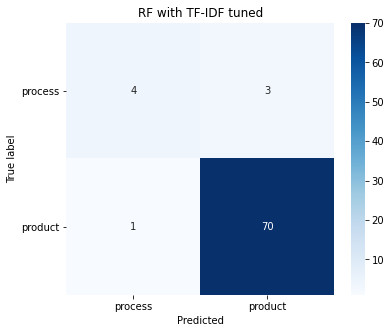

In [60]:
db['label'] = db.label.replace(to_replace=['use claim', 'product and process'], value=['process', 'product'])
db.groupby(by='label').count()
#https://github.com/miguelfzafra/Latest-News-Classifier/blob/master/0.%20Latest%20News%20Classifier/04.%20Model%20Training/06.%20MT%20-%20Random%20Forest.ipynb
aux_db = db[['label']].drop_duplicates().sort_values('label')
conf_matrix = metrics.confusion_matrix(y_test, best_model_pred)
plt.figure(figsize=(6,5))
aux_db['label'] = aux_db.label.replace(to_replace=[1, 0], value=['Product', 'Process'])
conf = sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_db['label'].values, 
            yticklabels=aux_db['label'].values,
            cmap="Blues")
conf.set_yticklabels(conf.get_yticklabels(), rotation=360)
plt.ylabel('True label')
plt.xlabel('Predicted')
plt.title('RF with TF-IDF tuned')
plt.show()

In [61]:
grid_search_tfidf.best_params_

{'tfidf__max_features': 400, 'tfidf__norm': 'l2', 'tfidf__sublinear_tf': True}

## I will now merge both test and train dataset manually labelled and test the model if the results above only on the test data can be trustworthy.

I merge both features and targets form both train and test data

In [61]:
features_X = [X_train, X_test]
features_X = pd.concat(features_X)
targets_y = [y_train, y_test]
targets_y = pd.concat(targets_y)

I use the TF-IDF vectorizer tuned for the best model.

In [62]:
features_X_tf = tfidf_tune.transform(features_X).toarray()

I run the model on the whole labelled data.

In [63]:
best_model_pred_X_y = rf_tf_tune.predict(features_X_tf)
print("Accuracy on test data: \n",metrics.accuracy_score(targets_y, best_model_pred_X_y))
print("Classification report: \n",metrics.classification_report(targets_y, best_model_pred_X_y))
print('Confusion Matrix test: \n' + str(metrics.confusion_matrix(targets_y, best_model_pred_X_y)))

Accuracy on test data: 
 0.9123711340206185
Classification report: 
               precision    recall  f1-score   support

           0       0.50      0.59      0.54        17
           1       0.96      0.94      0.95       177

    accuracy                           0.91       194
   macro avg       0.73      0.77      0.75       194
weighted avg       0.92      0.91      0.92       194

Confusion Matrix test: 
[[ 10   7]
 [ 10 167]]


In [64]:
sc = calc_binary_class_metrics(targets_y, best_model_pred_X_y, 'RF TF tuned ', 'Original Labelled Data')
sc

,Model,Data,Precision,Recall,Specificity,F1-score,Accuracy,Bal Accuracy,AUC
0,RF TF tuned,Original Labelled Data,0.95977,0.943503,0.588235,0.951567,0.912371,0.765869,0.765869


In [62]:
#save the model
with open(ospath('~/final_project/Z_Best_models_saved/Abstracts/Best_Binary_Keyword_model.pickle.pickle'), 'wb') as model:
    pickle.dump(rf_tf_tune, model)
    
#save tf-df fitted vectorizer to use for the best model
with open(ospath('~/final_project/Z_Best_models_saved/Abstracts/Best_tf_idf_for_Binary_Keyword_model.pickle'), 'wb') as model:
    pickle.dump(tfidf_tune, model)